## Load imports and read data

In [93]:
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars.selectors as cs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pl.read_csv('../input_data/cbb_postseason_wins.csv')
print(df.shape)
display(df.head())

(748, 25)


TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_WINS
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64
"""North Carolina""","""ACC""",40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,"""2ND""",1,2016,5
"""Wisconsin""","""B10""",40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,"""2ND""",1,2015,5
"""Michigan""","""B10""",40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,"""2ND""",3,2018,5
"""Texas Tech""","""B12""",38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,"""2ND""",3,2019,5
"""Gonzaga""","""WCC""",39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,"""2ND""",1,2017,5


## Get the average wins by seed as a baseline for prediction accuracy

In [2]:
avg_wins = (df
    .group_by('SEED').agg(pl.col('POSTSEASON_WINS').mean())
    .sort('SEED')
)
avg_wins

SEED,POSTSEASON_WINS
i64,f64
1,3.113636
2,2.090909
3,1.8
4,1.72093
5,1.136364
…,…
12,0.456522
13,0.222222
14,0.159091


## Prep data:
* We currently have non-numeric data: TEAM, CONF, POSTSEASON
* POSTSEASON has already been translated to POSTSEASON_WINS 
* We will not use team as the same teams won't always make it and we can't use it to predict for a new team
* We can use conference though as the winner of each conference makes the tournament each year, so there will always be a representative
    * Possible in the future there is realignment and changes so we should potentially rethink if that happens
* We will one-hot encode the conferences to make them numerical

In [9]:
df_prep = (df
           .select(pl.all().exclude('TEAM', 'POSTSEASON'))
           .to_dummies(['CONF'])
)

df_prep.head(3)

CONF_A10,CONF_ACC,CONF_AE,CONF_ASun,CONF_Amer,CONF_B10,CONF_B12,CONF_BE,CONF_BSky,CONF_BSth,CONF_BW,CONF_CAA,CONF_CUSA,CONF_Horz,CONF_Ivy,CONF_MAAC,CONF_MAC,CONF_MEAC,CONF_MVC,CONF_MWC,CONF_NEC,CONF_OVC,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,POSTSEASON_WINS
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,2016,5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,2015,5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3,2018,5


## Check some correlations to see if we can gather anything. A few observations:
* Seed seems to have the strongest correlation with postseason wins which makes sense as we saw previously that better seeds have more wins on average
* Adding the conference helps a little bit, but it adds a lot of variables and doesn't seem nearly as promising as all of the other categories so it will be best to leave it out from now on while doing analysis

In [ ]:
def plot_corr_heatmap(df_corr):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_corr, annot=False, fmt='.2f', xticklabels = df_corr.columns, yticklabels = df_corr.columns)
    plt.show()

df_corr_w_conf = df_prep.corr()

df_corr_wo_conf = (df_prep.select(~cs.starts_with('CONF'))).corr()

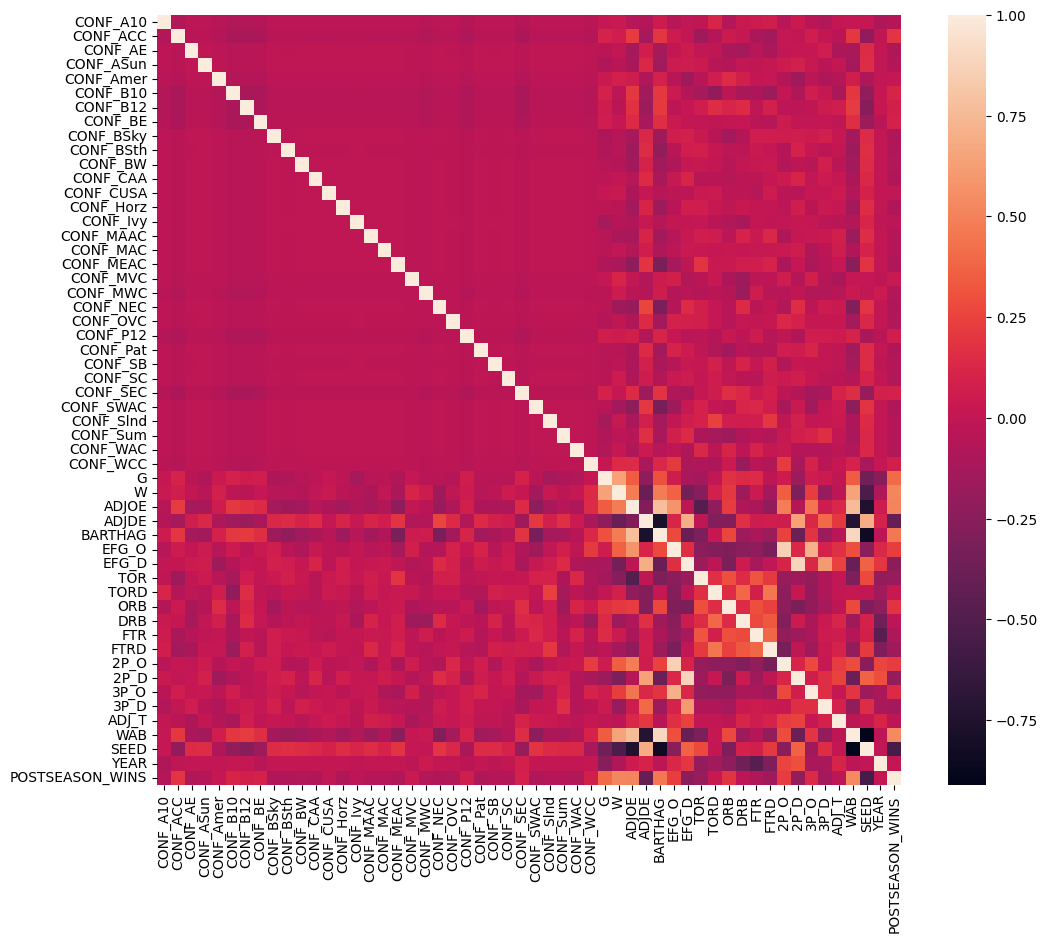

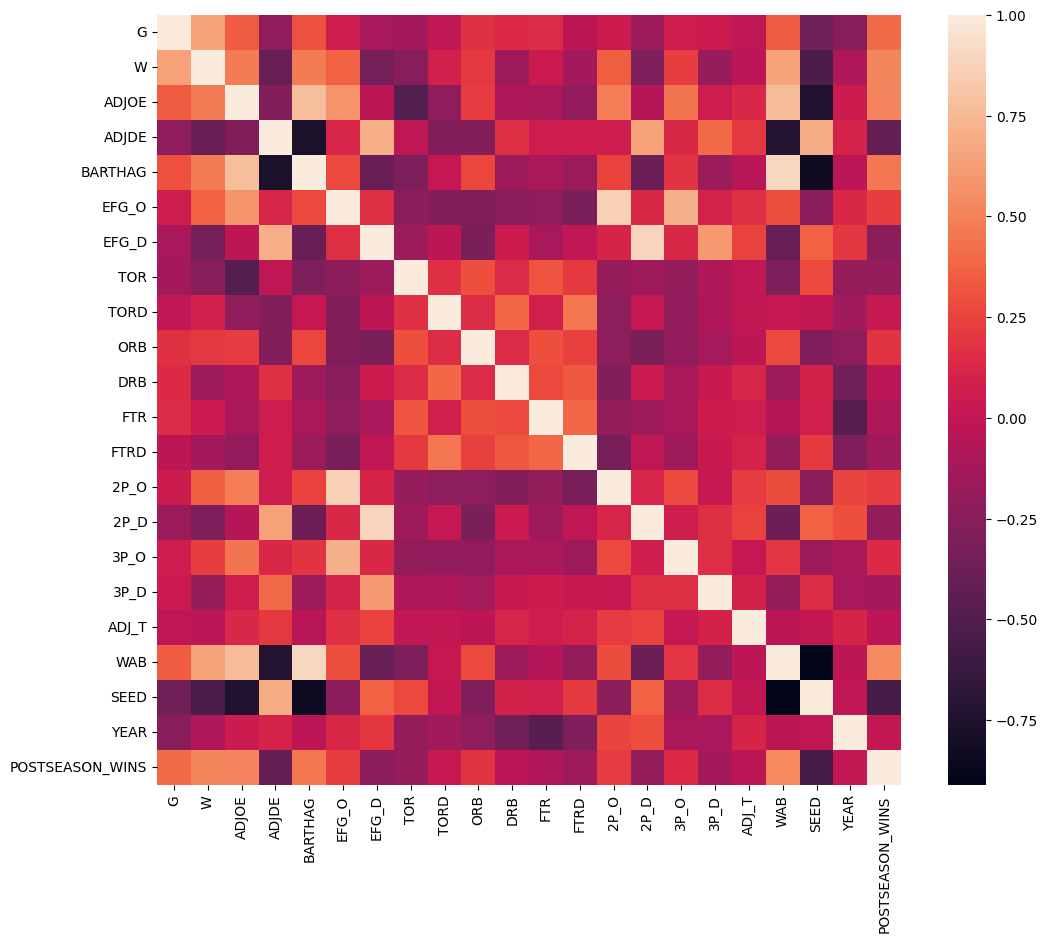

In [44]:
plot_corr_heatmap(df_corr_w_conf)
plot_corr_heatmap(df_corr_wo_conf)

In [ ]:
## remove conferences
df_prep = (df_prep.select(~cs.starts_with('CONF')))
df_prep.head(2)

G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,POSTSEASON_WINS
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,2016,5
40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,2015,5


## Create a bunch of univarirate regression models and see which is best


https://www.datacamp.com/tutorial/sklearn-linear-regression

In [ ]:
def uni_linear_reg_r2(df, x_var):

    ## create a pipeline to automatically do a standard scaler and linear regression
    uni_linear_reg_pipe = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])

    x = df.select(x_var)
    y = df.select('POSTSEASON_WINS')

    ## Standard 80/20 test/train split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84305)

    ## call the pipeline to get the score
    r2 = uni_linear_reg_pipe.fit(x_train, y_train).score(x_test, y_test)

    return r2

In [133]:
test_cols_r2 = {}
test_cols = df_prep.select(pl.exclude('POSTSEASON_WINS')).columns
for x_var in test_cols:
    r2 = uni_linear_reg_r2(df_prep, x_var)
    test_cols_r2[x_var] = round(r2, 3)

test_cols_r2

{'G': 0.215,
 'W': 0.224,
 'ADJOE': 0.088,
 'ADJDE': 0.154,
 'BARTHAG': 0.151,
 'EFG_O': -0.12,
 'EFG_D': 0.069,
 'TOR': -0.064,
 'TORD': -0.004,
 'ORB': 0.057,
 'DRB': -0.018,
 'FTR': -0.01,
 'FTRD': -0.022,
 '2P_O': -0.118,
 '2P_D': 0.042,
 '3P_O': -0.031,
 '3P_D': 0.03,
 'ADJ_T': -0.003,
 'WAB': 0.222,
 'SEED': 0.195,
 'YEAR': -0.007}

Things we learn:
* Top performers: 
    * G: games, positive correlation (makes sense, more games = made it further in conf tourney) 
    * W: wins, makes sense, more regular season wins are better
    * ADJDE: adjusted defense, perhaps defense does win championships?
    * BARTHAG: Power rating - should be a good indicator if its accurate
    * WAB: wins above bubble - makes sense, if you are beating teams that barely missed the tourney you should beat a decent amount that did make it
    * SEED: we already saw top seeds are going to win more

* Note: there might be some collinearity going on when dive deeper - won't good seeds be good at all this other stuff?

* Poor performers: TORD, FTR, ADJ_T, Year
    * TORD: turnover percentage committed (steal rate)
    * FTR: free throw rate - how often you get to the line - officiating can be different
    * ADJ_T: adjusted tempo - different teams have different styles, no style is superior overall
    * Year: We should remove year. Thats a poor indicator column and will not help us predict on new data

* A lot of the O stats are negatively correlated with wins, thats a bit unexpected

More variables that could be helpful in future analysis now that we are thinking about some of these:
* Win percentage (W/G)
* Strength of Schedule
* Strength of Victory
* Quadrant 1-4 wins and losses (this is used as part of the criteria for picking tournament teams, would be intersting to see if it actually resulted in picking teams that do better in the tournament)

## TO DO:
* Avg wins by seed
* Correlation matrix - figure out which variables are highly correlated and might be confounding
* Linear Regression
* Non Linear regression
* NN
* KNN
* Decision tree
* Random Forest
* Single variable predictions - will a team make the final four (equivalent of 4 wins)
* Multivariable prediction - how many games do we expect a team to win
